In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tonic
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tonic
import tonic.transforms as transforms

<IPython.core.display.Javascript object>

In [3]:
transform = tonic.transforms.Compose(
    [
        transforms.Downsample(time_factor=1e-3, spatial_factor=0.5),
        transforms.ToFrame(n_time_bins=120, merge_polarities=True),
        tonic.transforms.NumpyAsType("float32")
        # tonic.transforms.ToSparseTensor(merge_polarities=True),
    ]
)

download = False
trainset = tonic.datasets.DVSGesture(
    save_to="../data", transform=transform, download=download, train=True
)
testset = tonic.datasets.DVSGesture(
    save_to="../data", download=download, transform=transform, train=False
)

<IPython.core.display.Javascript object>

In [4]:
len(trainset)

1077

<IPython.core.display.Javascript object>

In [5]:
events = trainset[0][0]
print(f"events shape: {events.shape}")

events shape: (120, 1, 64, 64)


<IPython.core.display.Javascript object>

In [6]:
no_classes = len(trainset.classes)
print(f"number of classes: {no_classes}")
trainset.classes

number of classes: 11


['hand_clapping',
 'right_hand_wave',
 'left_hand_wave',
 'right_arm_clockwise',
 'right_arm_counter_clockwise',
 'left_arm_clockwise',
 'left_arm_counter_clockwise',
 'arm_roll',
 'air_drums',
 'air_guitar',
 'other_gestures']

<IPython.core.display.Javascript object>

In [7]:
len(trainset.targets)

1077

<IPython.core.display.Javascript object>

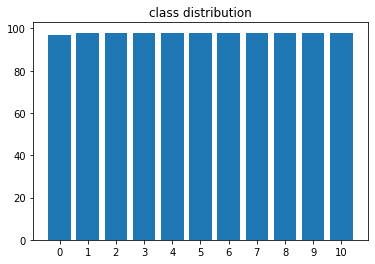

<IPython.core.display.Javascript object>

In [8]:
from collections import Counter

dis = np.unique(np.array(trainset.targets), return_counts=True)[1]
fig, ax = plt.subplots()
rects = ax.bar(range(11), dis)
ax.set_xticks([ind for ind in range(11)])
ax.set_xticklabels(range(11))
plt.title("class distribution")
plt.show()

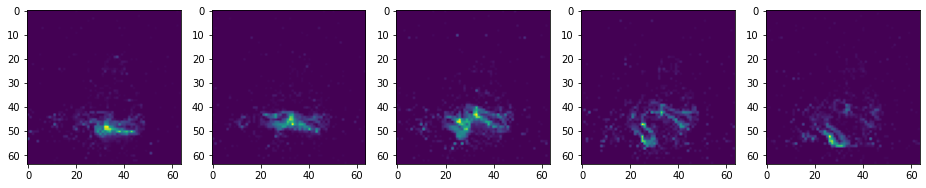

<IPython.core.display.Javascript object>

In [9]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 12))
columns = 5
rows = 1
for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(events[i, 0])
plt.show()

In [10]:
BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

<IPython.core.display.Javascript object>

In [29]:
class CNN3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 32, (2, 2, 2), padding=2)
        self.conv2 = nn.Conv3d(32, 64, (2, 2, 2), padding=2)
        self.conv3 = nn.Conv3d(64, 128, (2, 2, 2), padding=2)
        self.pool = nn.MaxPool3d((6, 2, 2))
        self.fc1 = nn.Linear(128 * 1 * 10 * 10, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 11)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        x = F.softmax(self.fc3(x), 1)
        return x

<IPython.core.display.Javascript object>

In [30]:
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

In [31]:
EPOCHS = 3

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

DEVICE = torch.device("cpu")

print(f"Running on {DEVICE}")

cnn = CNN3D().to(DEVICE)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

cnn.train()

for epoch in tqdm(range(EPOCHS)):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(tqdm(train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(DEVICE).permute((0, 2, 1, 3, 4))
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finished Training")

Running on cpu


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

Finished Training


<IPython.core.display.Javascript object>

In [32]:
cnn.eval()

with torch.no_grad():
    test_loss = 0
    correct = 0

    outputs = []
    targets = []

    for data, target in tqdm(test_loader):
        # get the inputs; data is a list of [inputs, labels]

        data = data.to(DEVICE).permute((0, 2, 1, 3, 4))
        target = target.to(DEVICE)

        output = cnn(data)

        outputs.append(output)
        targets.append(target)

        test_loss += torch.nn.functional.nll_loss(
            output, target, reduction="sum"
        ).item()  # sum up batch loss
        pred = output.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

  0%|          | 0/33 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [33]:
print(f"Loss: {test_loss}")
print(f"Accuracy: {accuracy}")

Loss: -0.5332207851337664
Accuracy: 56.43939393939394


<IPython.core.display.Javascript object>

In [34]:
pred = torch.cat([t.argmax(dim=1) for t in outputs])
pred = pred.to(torch.device("cpu"))

<IPython.core.display.Javascript object>

In [35]:
targets = torch.cat(targets).to(torch.device("cpu"))

<IPython.core.display.Javascript object>

In [36]:
from sklearn.metrics import f1_score

f1_score(targets, pred, average="macro")

0.48009932946592465

<IPython.core.display.Javascript object>